# 1. Text preprocessing

1.1. Getting data

In [2]:
with open('decart.txt', 'r', encoding = "utf-8") as f:
  X = f.read()

X

'Разыскание истины посредством естественного света, который сам по себе, не прибегая к содействию религии или философии, определяет мнения, кои должен иметь добропорядочный человек относительно всех предметов, могущих занимать его мысли, и проникает в тайны самых любопытных наук\n\nДобропорядочный человек не обязан перелистать все книги или тщательно усвоить все то, что преподают в школах; более того, если бы он потратил чересчур много времени на изучение книг, это образовало бы некий пробел в его воспитании. В течение жизни ему необходимо совершить много иных дел, и его жизненный досуг должен быть распределен настолько верно, чтобы бо?льшая часть этого досуга отводилась на свершение добрых дел, понятие о которых бывает ему внушено его разумом, даже если он иных наставлений не получает. Однако в этот мир он приходит невежественным, и, поскольку ранние его познания основываются лишь на неразвитом чувственном восприятии и на авторитете его наставников, почти невозможно, чтобы воображение

1.2 Normalizing text

In [3]:
import nltk
import re

# X = re.split(r'Введение\n', X)[1]
# X = re.split(r'notes\n', X)[0]
# X = re.sub(r'\[M-\d+\]', '', X)
X = re.sub(r'\xa0', ' ', X)
X = re.sub(r'\n+', '', X)
X = re.sub(r'Полиандр\.|Эпистемон\.|Евдокс\.', '', X)

nltk.download('punkt')
X = nltk.tokenize.sent_tokenize(X)
print(len(X))
X

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\markg\AppData\Roaming\nltk_data...


238


[nltk_data]   Unzipping tokenizers\punkt.zip.


['Разыскание истины посредством естественного света, который сам по себе, не прибегая к содействию религии или философии, определяет мнения, кои должен иметь добропорядочный человек относительно всех предметов, могущих занимать его мысли, и проникает в тайны самых любопытных наукДобропорядочный человек не обязан перелистать все книги или тщательно усвоить все то, что преподают в школах; более того, если бы он потратил чересчур много времени на изучение книг, это образовало бы некий пробел в его воспитании.',
 'В течение жизни ему необходимо совершить много иных дел, и его жизненный досуг должен быть распределен настолько верно, чтобы бо?льшая часть этого досуга отводилась на свершение добрых дел, понятие о которых бывает ему внушено его разумом, даже если он иных наставлений не получает.',
 'Однако в этот мир он приходит невежественным, и, поскольку ранние его познания основываются лишь на неразвитом чувственном восприятии и на авторитете его наставников, почти невозможно, чтобы вообра

1.3 Vectorization

In [7]:
!python -m spacy download ru_core_news_md

     --------------------------------------- 41.9/41.9 MB 50.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')


In [8]:
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('ru_core_news_md')
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def tokenizer(sent):
  return [token.lemma_ for token in nlp(sent) if token.is_alpha]

stop_words = stopwords.words('russian')
vectorizer = CountVectorizer(binary=True,
                             stop_words = stop_words,
                             tokenizer = tokenizer)
data = vectorizer.fit_transform(X)
data = pd.DataFrame(data.todense(),
                    columns=vectorizer.get_feature_names_out())
data.info()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\markg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\markg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\markg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['весь', 'мочь', 'ничто', 'свой', 'хороший', 'это'] not in stop_words.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Columns: 1785 entries, entendement to ясный
dtypes: int64(1785)
memory usage: 3.2 MB


# 2. Clustering tokens

2.1 Agglomeration model fitting

In [9]:
from sklearn.cluster import FeatureAgglomeration

model = FeatureAgglomeration(n_clusters = None, distance_threshold = 0.1)
model.fit(data)
max_dist = max(model.distances_)

max_dist

16.631887074001487

2.2 Hyperparameter search

In [10]:
import numpy as np

dims = []
step = max_dist/50
for i in np.arange(step, max_dist, step):
  model = FeatureAgglomeration(n_clusters = None, distance_threshold = i)
  clusters = model.fit_transform(data)
  dims.append({'param': round(i, 3),
               'dim': clusters.shape[1]})
  
dims[:5]

[{'param': 0.333, 'dim': 943},
 {'param': 0.665, 'dim': 943},
 {'param': 0.998, 'dim': 943},
 {'param': 1.331, 'dim': 752},
 {'param': 1.663, 'dim': 637}]

2.3 Calculating differences

In [11]:
last = len(dims) - 1
dims[last]['diff'] = 0
for i, dim in enumerate(dims):
  if i == last:
    break
  dim['diff'] = dim['dim'] - dims[i+1]['dim']
dims[:5]

[{'param': 0.333, 'dim': 943, 'diff': 0},
 {'param': 0.665, 'dim': 943, 'diff': 0},
 {'param': 0.998, 'dim': 943, 'diff': 191},
 {'param': 1.331, 'dim': 752, 'diff': 115},
 {'param': 1.663, 'dim': 637, 'diff': 134}]

2.4 Visualizing

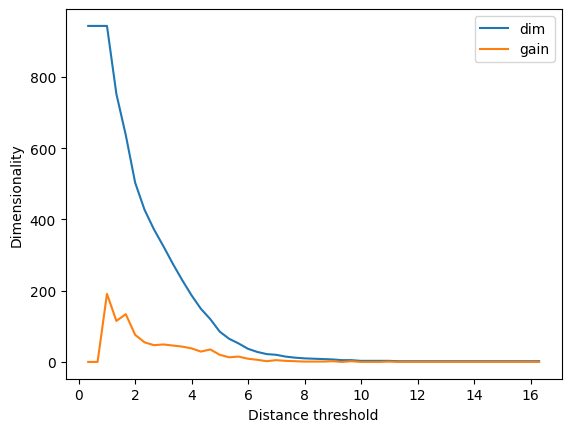

In [12]:
from matplotlib import pyplot as plt

param_list = [x['param'] for x in dims]
dim_list = [x['dim'] for x in dims]
diff_list = [x['diff'] for x in dims]

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('Dimensionality')
ax.set_xlabel('Distance threshold')
plt.plot(param_list, dim_list, label='dim')
plt.plot(param_list, diff_list, label='gain')
ax.legend()
plt.show()

2.5 Getting optimal cut

In [13]:
dims_sorted = sorted(dims, key=lambda x: x['diff'], reverse=True)
threshold = dims_sorted[0]['param']

model = FeatureAgglomeration(n_clusters = None,
                             distance_threshold = threshold,
                             pooling_func = np.min)
data_clustered = model.fit_transform(data)
data_clustered = pd.DataFrame(data_clustered)
labels = model.labels_

data_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Columns: 943 entries, 0 to 942
dtypes: int64(943)
memory usage: 1.7 MB


# 3. Relation extraction

3.1 Getting itemsets

In [15]:
from mlxtend.frequent_patterns import apriori

min_support = 2/len(data)
itemsets = apriori(data_clustered,
                   min_support = min_support,
                   max_len = 2)
itemsets

C:\Users\markg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.012605,(0)
1,0.008403,(1)
2,0.008403,(2)
3,0.008403,(3)
4,0.008403,(4)
...,...,...
6117,0.008403,"(896, 898)"
6118,0.008403,"(905, 901)"
6119,0.008403,"(907, 901)"
6120,0.008403,"(929, 908)"


3.2 Searching

In [16]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(itemsets, min_threshold = min_support)
rules['antecedents'] = rules['antecedents'].apply(lambda x: list(x)[0])
rules['consequents'] = rules['consequents'].apply(lambda x: list(x)[0])

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,0,216,0.012605,0.021008,0.008403,0.666667,31.733333,0.008139,2.936975
1,216,0,0.021008,0.012605,0.008403,0.400000,31.733333,0.008139,1.645658
2,0,833,0.012605,0.142857,0.008403,0.666667,4.666667,0.006603,2.571429
3,833,0,0.142857,0.012605,0.008403,0.058824,4.666667,0.006603,1.049107
4,1,511,0.008403,0.289916,0.008403,1.000000,3.449275,0.005967,inf
...,...,...,...,...,...,...,...,...,...
10771,901,907,0.025210,0.008403,0.008403,0.333333,39.666667,0.008192,1.487395
10772,929,908,0.058824,0.021008,0.008403,0.142857,6.800000,0.007168,1.142157
10773,908,929,0.021008,0.058824,0.008403,0.400000,6.800000,0.007168,1.568627
10774,934,919,0.008403,0.021008,0.008403,1.000000,47.600000,0.008227,inf


3.3 Searching for inclusions

In [17]:
incls = rules[rules['confidence'] == 1]
incls = incls[['antecedents', 'consequents']]

incls

,antecedents,consequents
4,1,511
6,1,517
8,1,619
10,1,775
12,2,147
...,...,...
10738,844,847
10742,848,933
10749,910,852
10770,907,901


# 4. Knowledge Graph

4.1 Creating ontology

In [18]:
from owlready2 import *
import types

onto = get_ontology('http://onto.owl')

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


4.2 Creating individuals for sentences

In [19]:
with onto:
  onto_sent = types.new_class('Sentence', (Thing,))
  types.new_class('hasText', (DataProperty, FunctionalProperty))
  for i, sent in enumerate(X):
    sent_inst = onto_sent(f'sentence_{i}')
    sent_inst.hasText = sent
    
onto.save('onto.owl')

4.3 Creating classes for tokens

In [20]:
with onto:
  onto_token = types.new_class('Token', (Thing,))
  for i, token in enumerate(data.columns):
    token_inst = onto_token(f'token_{i}')
    token_inst.label = token

onto.save('onto.owl')

4.4 Linking sentences with tokens

In [21]:
with onto:
  hasToken = types.new_class('hasToken', (ObjectProperty,))
  for i, row in data.iterrows():
    sent_inst = onto[f'sentence_{i}']
    for j, token in enumerate(data.columns):
      if row[token] == 1:
        token_inst = onto[f'token_{j}']
        sent_inst.hasToken.append(token_inst)

onto.save('onto.owl')

4.5 Creating clusters

In [22]:
with onto:
  onto_clust = types.new_class('Cluster', (Thing,))
  for label in set(labels):
    clust_cl = types.new_class(f'Cluster_{label}', (onto_clust,))

onto.save('onto.owl')

4.6 Linking clusters with tokens

In [23]:
with onto:
  for i, label in enumerate(labels):
    clust_cl = onto[f'Cluster_{label}']
    token_inst = onto[f'token_{i}']
    clust_cl.equivalent_to.append(hasToken.value(token_inst))
onto.save('onto.owl')

4.7 Setting inclusions

In [24]:
with onto:
  for index, row in incls.iterrows():
    ant = row['antecedents']
    con = row['consequents']
    ant_cl = onto[f'Cluster_{ant}']
    con_cl = onto[f'Cluster_{con}']
    reverse = incls[(incls['antecedents'] == con) & (incls['consequents'] == ant)]
    if reverse.empty:
      ant_cl.is_a.append(con_cl)
    else:
      ant_cl.equivalent_to.append(con_cl)
      
onto.save('onto.owl')

4.8 Running reasoner

In [25]:
with onto:
  sync_reasoner_pellet()

onto.save('onto_reasoned.owl', format='ntriples')

* Owlready2 * Running Pellet...
    java -Xmx2000M -cp C:\Users\markg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\owlready2\pellet\antlr-3.2.jar;C:\Users\markg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\owlready2\pellet\antlr-runtime-3.2.jar;C:\Users\markg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\owlready2\pellet\aterm-java-1.6.jar;C:\Users\markg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\owlready2\pellet\commons-codec-1.6.jar;C:\Users\markg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\owlready2\pellet\httpclient-4.2.3.jar;C:\Users\markg\AppData\Local\Packages\PythonSoftwareFoundation.Pyth